Revert Extraction Analysis
===

Do some analysis on reverts.

In [1]:
import mwapi
import mwxml
import mwxml.utilities
import mwcli
import mwreverts
import oresapi
import mwparserfromhell

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import os
from tqdm import tqdm
import bz2
import gzip
import json
import re
import hashlib
from datetime import datetime
import nltk
import scipy.stats
import para
from itertools import groupby
from collections import Counter

In [4]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
git_root_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback'

In [5]:
raw_data_dir = "/export/scratch2/wiki_data"
derived_data_dir = os.path.join(git_root_dir, "data", "derived")
raw_data_dir, derived_data_dir

('/export/scratch2/wiki_data',
 '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived')

In [6]:
working_dir = os.path.join(derived_data_dir, 'stub-history-reverts')
os.makedirs(working_dir, exist_ok=True)
working_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-reverts'

In [7]:
article_index_path = os.path.join(raw_data_dir, "enwiki-20200101-pages-articles-multistream-index.txt")
article_index = open(article_index_path).readlines()
len(article_index)

19881980

In [8]:
page_title_dict = {}
for line in tqdm(article_index):
    tokens = line.strip().split(":")
    #page_start_bytes = int(tokens[0])
    page_id = int(tokens[1])
    page_title = "".join(tokens[2:])
    page_title_dict[page_id] = page_title
len(page_title_dict)

100%|██████████| 19881980/19881980 [00:33<00:00, 594735.35it/s]


19881980

In [9]:
stub_history_dir = os.path.join(raw_data_dir, "enwiki-20200101-stub-meta-history-gz")
assert os.path.exists(stub_history_dir)

In [10]:
paths = [os.path.join(stub_history_dir, stub_history_filename) 
         for stub_history_filename in os.listdir(stub_history_dir)
         if stub_history_filename.endswith(".xml.gz")]
len(paths)

27

In [11]:
start_date = datetime.fromisoformat('2018-01-01')
start_timestamp = int(start_date.timestamp())
end_date = datetime.fromisoformat('2020-01-01')
end_timestamp = int(end_date.timestamp())
start_timestamp, end_timestamp

(1514786400, 1577858400)

### Load in all revisions

Which excludes revisions outside of 2018-2020 and only for pages in ns0 and non-redirects.

In [13]:
start = datetime.now()
rev_ids_filepath = os.path.join(working_dir, 'rev_ids_sorted.csv')
df = pd.read_csv(rev_ids_filepath,
                 header=None, 
                 names=['page_id', 'rev_id', 'rev_timestamp', 'is_revert_target', 'is_reverted', 'is_reverting']
)
print(f"{datetime.now() - start}")
len(df)

0:00:35.786140


77287697

In [15]:
df.head()

,page_id,rev_id,rev_timestamp,is_revert_target,is_reverted,is_reverting
0,12,818611292,1515101356,0,0,0
1,12,818613649,1515102279,0,0,0
2,12,818624114,1515106953,1,0,0
3,12,820024812,1515798752,0,1,0
4,12,820025687,1515799060,0,0,1


In [14]:
# number of unique pages in this sample
page_ids_set = set(df.page_id)
len(page_ids_set)

5338582

In [18]:
is_revert_target_count = np.sum(df.is_revert_target)
is_reverted_count = np.sum(df.is_reverted)
is_reverting_count = np.sum(df.is_reverting)
print(f"Is revert target: {is_revert_target_count} ({is_revert_target_count / len(df) * 100:.2f}%)")
print(f"Is reverted: {is_reverted_count} ({is_reverted_count / len(df) * 100:.2f}%)")
print(f"Is reverting: {is_reverting_count} ({is_reverting_count / len(df) * 100:.2f}%)")

Is revert target: 5712814 (7.39%)
Is reverted: 8335521 (10.79%)
Is reverting: 5992682 (7.75%)


In [33]:
bins = []
bins.append(int(start_date.timestamp()))
year = 2018
month = 1
while not (year == 2020 and month == 1):
    if month == 12:
        year += 1
        month = 1
    else:
        month += 1
    bins.append(int(datetime.fromisoformat(f"{year}-{month:02}-01").timestamp()))
len(bins)

25

In [50]:
cmap = matplotlib.cm.Set2

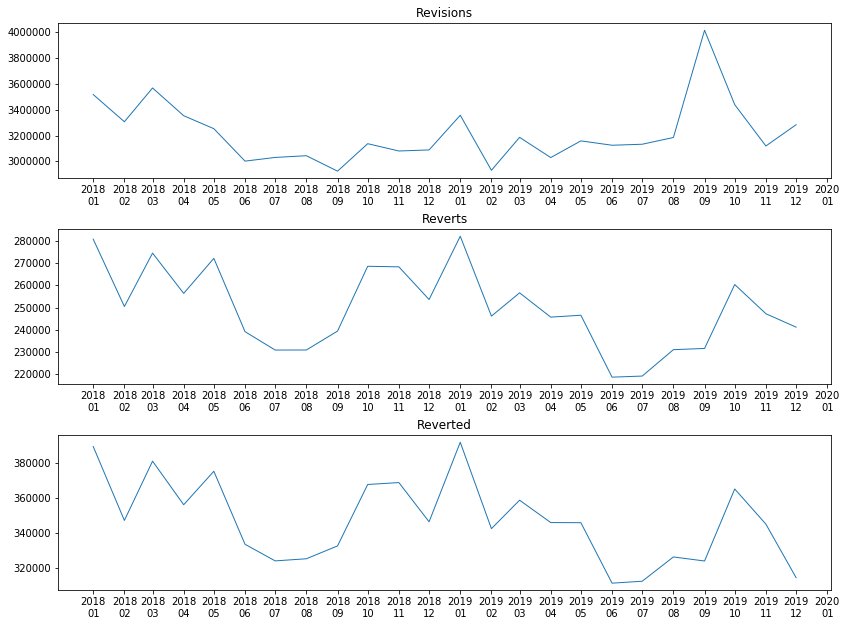

In [56]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9))
fig.tight_layout(pad=3)

ax = axes[0]
hist, bin_edges = np.histogram(df.rev_timestamp, bins=bins)
ax.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='Revisions')
ax.set_xticks(bins)
ax.set_xticklabels([datetime.utcfromtimestamp(ts).strftime('%Y\n%m') for ts in bins])
ax.set_title("Revisions")

ax = axes[1]
hist, bin_edges = np.histogram(df[df.is_reverting == 1].rev_timestamp, bins=bins)
ax.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='Revisions')
ax.set_xticks(bins)
ax.set_xticklabels([datetime.utcfromtimestamp(ts).strftime('%Y\n%m') for ts in bins])
ax.set_title("Reverts")

ax = axes[2]
hist, bin_edges = np.histogram(df[df.is_reverted == 1].rev_timestamp, bins=bins)
ax.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='Revisions')
ax.set_xticks(bins)
ax.set_xticklabels([datetime.utcfromtimestamp(ts).strftime('%Y\n%m') for ts in bins])
ax.set_title("Reverted")


plt.show()

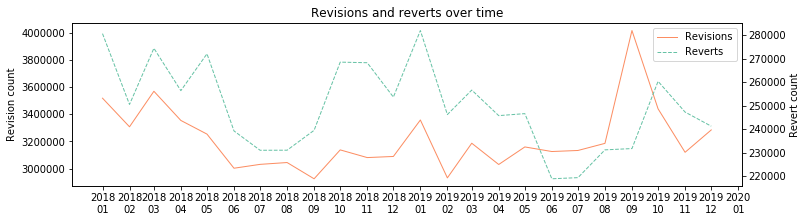

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

hist, bin_edges = np.histogram(df.rev_timestamp, bins=bins)
ln1 = ax.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='Revisions', color=cmap(0.2))
ax.set_xticks(bins)
ax.set_xticklabels([datetime.utcfromtimestamp(ts).strftime('%Y\n%m') for ts in bins])
ax.set_title("Revisions and reverts over time")
ax.set_ylabel("Revision count")

ax2 = ax.twinx()
hist, bin_edges = np.histogram(df[df.is_reverting == 1].rev_timestamp, bins=bins)
ln2 = ax2.plot(bin_edges[:-1], hist, linestyle='--', linewidth=1, label='Reverts', color=cmap(0))
ax2.set_ylabel("Revert count")

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs)

plt.show()

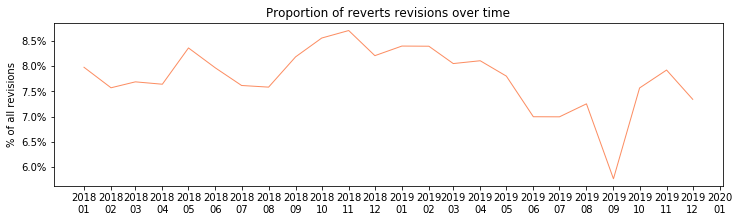

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

hist, bin_edges = np.histogram(df.rev_timestamp, bins=bins)
revert_hist, _ = np.histogram(df[df.is_reverting == 1].rev_timestamp, bins=bins)
pct_reverts = revert_hist / hist * 100
ln1 = ax.plot(bin_edges[:-1], pct_reverts, linestyle='-', linewidth=1, color=cmap(0.2))
ax.set_xticks(bins)
ax.set_xticklabels([datetime.utcfromtimestamp(ts).strftime('%Y\n%m') for ts in bins])
ax.set_yticklabels([f"{val:.1f}%" for val in ax.get_yticks()])
ax.set_title("Proportion of reverts revisions over time")
ax.set_ylabel("% of all revisions")

plt.show()

In [63]:
res = df.groupby(by='page_id').agg({'rev_timestamp': lambda ts: np.concatenate(([0], np.diff(ts)))})

Exception: Must produce aggregated value

In [64]:
curr_page_id = -1
prev_row = None
time_between_revs = []
for row in tqdm(df.itertuples(), total=len(df)):
    page_id = row.page_id
    if page_id == curr_page_id:
        time_to_last_rev = row.rev_timestamp - prev_row.rev_timestamp
        time_between_revs.append(time_to_last_rev)
    else:
        curr_page_id = page_id
        time_between_revs.append(0)
    prev_row = row

100%|██████████| 77287697/77287697 [02:32<00:00, 506636.66it/s]


In [65]:
df['time_between_revs'] = time_between_revs

In [68]:
mean_time_between_revs = df.groupby(by='page_id').agg({'time_between_revs': np.mean})

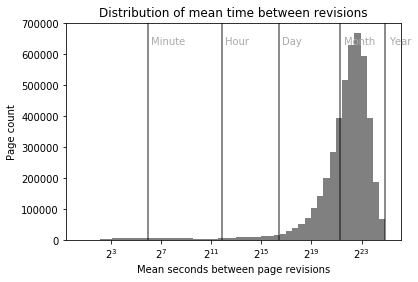

In [76]:
x = np.clip(mean_time_between_revs.time_between_revs, 1, None)
x = x[x > 1]
num_bins=50
base = 2
logbins = np.logspace(np.log2(min(x)), np.log2(max(x)), num=num_bins, base=base, endpoint=True)
plt.hist(x, bins=logbins, color='gray')
plt.xscale('log', nonposx='clip', basex=base)

ax = plt.gca()
# add semantically interpretable time moments
ax.axvline(1 * 60, color='black', alpha=0.6)
ax.axvline(1 * 60 * 60, color='black', alpha=0.6)
ax.axvline(1 * 60 * 60 * 24, color='black', alpha=0.6)
ax.axvline(1 * 60 * 60 * 24 * 30, color='black', alpha=0.6)
ax.axvline(1 * 60 * 60 * 24 * 365, color='black', alpha=0.6)
text_y = ax.transData.inverted().transform((0, ax.transAxes.transform((0, 0.90))[1]))[1]  # https://matplotlib.org/users/transforms_tutorial.html
ax.text(1 * 60 * 1.2, text_y, 'Minute', color='darkgray')
ax.text(1 * 60 * 60 * 1.2, text_y, 'Hour', color='darkgray')
ax.text(1 * 60 * 60 * 24 * 1.2, text_y, 'Day', color='darkgray')
ax.text(1 * 60 * 60 * 24 * 30 * 1.2, text_y, 'Month', color='darkgray')
ax.text(1 * 60 * 60 * 24 * 365 * 1.2, text_y, 'Year', color='darkgray')

plt.title("Distribution of mean time between revisions")
plt.xlabel("Mean seconds between page revisions")
plt.ylabel("Page count")

plt.show()

In [79]:
revs_per_page = df.groupby(by='page_id').agg({
    'rev_id': len,
    'is_reverting': np.sum,
    'is_reverted': np.sum
}).rename(columns={
    'rev_id': 'rev_count',
    'is_reverting': 'reverting_count',
    'is_reverted': 'reverted_count'
})
len(revs_per_page)

5338582

In [81]:
revs_per_page['pct_reverted'] = revs_per_page.reverted_count / revs_per_page.rev_count
revs_per_page['pct_reverting'] = revs_per_page.reverting_count / revs_per_page.rev_count

In [82]:
revs_per_page.head()

,rev_count,reverting_count,reverted_count,pct_reverted,pct_reverting
page_id,,,,,
12,1299,98,149,0.114704,0.075443
25,525,44,64,0.121905,0.083810
39,91,15,15,0.164835,0.164835
290,78,11,12,0.153846,0.141026
303,817,248,306,0.374541,0.303550


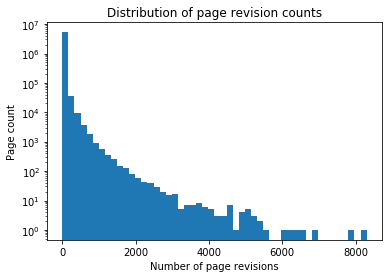

In [85]:
plt.hist(revs_per_page.rev_count, bins=50, log=True)
plt.xlabel("Number of page revisions")
plt.ylabel("Page count")
plt.title("Distribution of page revision counts")
plt.show()

In [87]:
# the middle 80% of pages have between 1 and 28 revisions
np.quantile(revs_per_page.rev_count, 0.1), np.quantile(revs_per_page.rev_count, 0.9)

(1.0, 28.0)

In [88]:
# 13.9% of pages have only a single revision in 2018-2020
np.sum(revs_per_page.rev_count == 1) / len(revs_per_page)

0.13881944681190622

In [89]:
pages = revs_per_page[revs_per_page.rev_count > 1]
len(pages), len(pages) / len(revs_per_page)

(4597483, 0.8611805531880937)

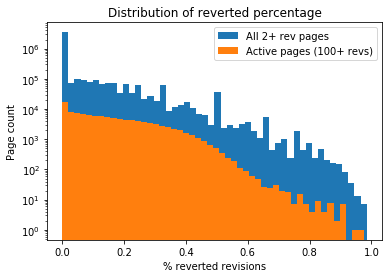

In [98]:
plt.hist(pages.pct_reverted, bins=50, log=True, label='All 2+ rev pages')
plt.hist(pages[pages.rev_count >= 100].pct_reverted, bins=50, log=True, label='Active pages (100+ revs)')
plt.xlabel("% reverted revisions")
plt.ylabel("Page count")
plt.title("Distribution of reverted percentage")
plt.legend()
plt.show()

In [96]:
# a very small percentage of pages are reverted more than 50% of the time, which is probably good
np.sum(pages.pct_reverted >= 0.5) / len(pages)

0.014435072408098083

In [105]:
# the median active page (2.1% of all pages) has 13.3% of its revisions reverted
# the median top-10% of pages (with 28+ revs) has 7.7% of its revisions reverted
active_pages = pages[pages.rev_count >= 28]
print(len(active_pages) / len(revs_per_page))
np.quantile(active_pages.pct_reverted, 0.5)

0.10042273397692496


0.07692307692307693